<a id="top"></a>
# Correcting for Scattered Light in WFC3/IR Exposures: Manually Subtracting Bad Reads


## Learning Goals

This notebook presents one of two available methods to correct for a time variable background (TVB) due to scattered light from observing close to the Earth's limb. This method illustrates how to manually subtract any bad reads from the final exposure read of the WFC3/IR IMA data. 

By the end of this tutorial, you will:

- Compute and plot the difference between IMA reads to identify those affected by TVB. 
- Correct a single exposure in which the first few reads are affected by scattered light by subtracting those "bad" reads from the final IMA read.
- Compare the original FLT to the reprocessed FLT image.

A second method for correcting TVB (masking bad reads in the RAW image and re-running `calwf3`) can be found in the notebook Correcting for Scattered Light in WFC3/IR Exposures: Using `calwf3` to Mask Bad Reads (O'Connor, in prep.). This method performs the 'ramp 
fitting' step in calwf3 and therefore removes cosmic rays from the final image. It only works, 
however, when TVB occurs at the beginning or end of the IR exposure and may leave sky 
residuals in regions flagged as IR 'blobs'.

<div class="alert alert-block alert-info">

**Please note that the FLT products in this notebook are really 'corrected IMA' 
files and therefore do not include the 'ramp fitting' step in calwf3.  The final images will 
therefore still contain cosmic rays, and these artifacts may be removed using software such 
as AstroDrizzle when combining multiple exposures.**
    
</div>

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#import) <br>
[2. Downloading Data](#load) <br>
[3. Identifying Reads with Earth-limb Scattered Light](#identify) <br>
[4. Querying CRDS for the Reference File](#ref) <br>

[5. Correcting the Data](#main) <br>
- [5.1 Excising "Bad" Reads](#reprocess) <br>
- [5.2 Comparing FLT Products](#compare) <br>

[6. Conclusions](#conclusions) <br>
[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>



## Introduction <a id="intro"></a>

WFC3 images can be affected by many different kinds of unwanted, non-science features,  such as satellite trails, peculiar cosmic rays, Earth-limb scattered light,  reflections off the filter wheel, and more. We call these features "anomalies". The majority of these anomalies are well studied, correctable, and easily identifiable, as discussed in  [WFC3 ISR 2017-22](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-22.pdf).


In this notebook, we will walk through the process of correcting WFC3/IR images for anomalies that appear in only some of the reads (see [section 7.7 of the WFC3 Instrument Handboook](https://hst-docs.stsci.edu/wfc3ihb/chapter-7-ir-imaging-with-wfc3/7-7-ir-exposure-and-readout) for a discussion of the WFC3/IR MULTIACCUM observing mode).  We examine 
an observation affected by a strong TVB due to Earth limb scattered light affecting the first few reads ([section 7.10 of the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb/chapter-7-wfc3-ir-sources-of-error/7-10-time-variable-background)). We will manually subtract the affected reads from the final read of the IMA and copy the updated science and error arrays into the FLT science and error arrays.  This method is based on section 5 of  [WFC3 ISR 2016-16: 'Excising Individual Reads'](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2016/WFC3-2016-16.pdf).  This same method can be used to remove individual reads that contain other anomalies, such as satellite trails.

This new FLT will have a reduced total exposure time (and signal-to-noise) given the rejection 
of some number of reads but will now have a flat background and an improved ramp fit.  

Please see the notebook WFC3/IR IMA Visualization with An Example of Time Variable Background (O'Connor, in prep.) for a walkthrough of how to identify a TVB due to scattered light. 

## 1. Imports <a id="import"></a>

This notebook assumes you have created the virtual environment in [WFC3 Library's](https://github.com/spacetelescope/WFC3Library) installation instructions.

We import:

- *os* for setting environment variables
- *glob* for finding lists of files
- *shutil* for managing directories
- *numpy* for handling array functions
- *matplotlib.pyplot* for plotting data
- *astropy.io fits* for accessing FITS files
- *astroquery.mast Observations* for downloading data from MAST
- *wfc3tools* `calwf3` for calibrating WFC3 data
- *ginga* for finding min/max outlier pixels

We import the following modules:
- *ima_visualization_and_differencing* to take the difference between reads, plot the ramp, and visualize the difference in images



In [1]:
import os 
import glob
import shutil 
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astroquery.mast import Mast
from astroquery.mast import Observations
from wfc3tools import calwf3
from ginga.util.zscale import zscale

import ima_visualization_and_differencing as diff

%matplotlib inline


## 2. Downloading Data<a id="load"></a>

The following commands query MAST for the necessary data products and download them to the current directory. Here we obtain WFC3/IR observations from HST Frontier Fields program [14037](https://archive.stsci.edu/proposal_search.php?id=14037&mission=hst), Visit BB. We specifically want the observation "icqtbbbxq", as it is strongly affected by Earth limb scattered light. The data products requested are the RAW, IMA, and FLT files.

**Warning: this cell may take a few minutes to complete.**

In [2]:
OBS_ID = 'ICQTBB020'
data_list = Observations.query_criteria(obs_id=OBS_ID)

file_id = "icqtbbbxq"
Observations.download_products(data_list['obsid'], project = 'CALWF3', obs_id = file_id, 
                mrp_only = False, productSubGroupDescription = ['RAW','IMA','FLT'])

INFO: Found cached file ./mastDownload/HST/icqtbbbxq/icqtbbbxq_ima.fits with expected size 168261120. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits with expected size 16583040. [astroquery.query]
INFO: Found cached file ./mastDownload/HST/icqtbbbxq/icqtbbbxq_raw.fits with expected size 34027200. [astroquery.query]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/icqtbbbxq/icqtbbbxq_ima.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbxq/icqtbbbxq_flt.fits,COMPLETE,None,None
./mastDownload/HST/icqtbbbxq/icqtbbbxq_raw.fits,COMPLETE,None,None


Now, we will copy our RAW file into our working directory to use in this tutorial. We copy the IMA and FLT files to a new directory called "orig/" for later use. 

In [3]:
if not os.path.exists('orig/'):
    os.mkdir('orig/')

shutil.copy(f'mastDownload/HST/{file_id}/{file_id}_ima.fits',f'orig/{file_id}_ima.fits')
shutil.copy(f'mastDownload/HST/{file_id}/{file_id}_flt.fits',f'orig/{file_id}_flt.fits')  

raw_file = f'mastDownload/HST/{file_id}/{file_id}_raw.fits'

shutil.copy(raw_file, f'{file_id}_raw.fits')

'icqtbbbxq_raw.fits'

## 3. Identifying Reads with Earth-limb Scattered Light<a id="identify"></a>

In this section, we show how to identify the reads impacted by the scattered light by examining the difference in count rate between reads. This section was taken from the [IR IMA Visualization with An Example of Time Variable Background ADD LINK]() notebook, which includes a more comprehensive walkthrough of identifying time variable background. 

Here we implement a technique to examine the count rate difference between consecutive reads. In this case, we first convert from count rate (electrons/second) back to counts (electrons) before taking the difference, as shown in equation 3 from [WFC3 ISR 2018-05](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2018/WFC3-2018-05.pdf).

![Instantaneous Difference Equation](instantaneous_diff.png)

We compare sky values in different regions of the detector (left side, right side, and full frame). If you would like to specify your own regions for the left and right sides of your image, you can change the `lhs_region` and `rhs_region` parameters. Each region must be specified as a dictionary including the four "corners" (x0, x1, y0, and y1) of the region you would like to select. You may want to avoid the edges of the detector which have a large number of bad pixels and higher flat field errors.

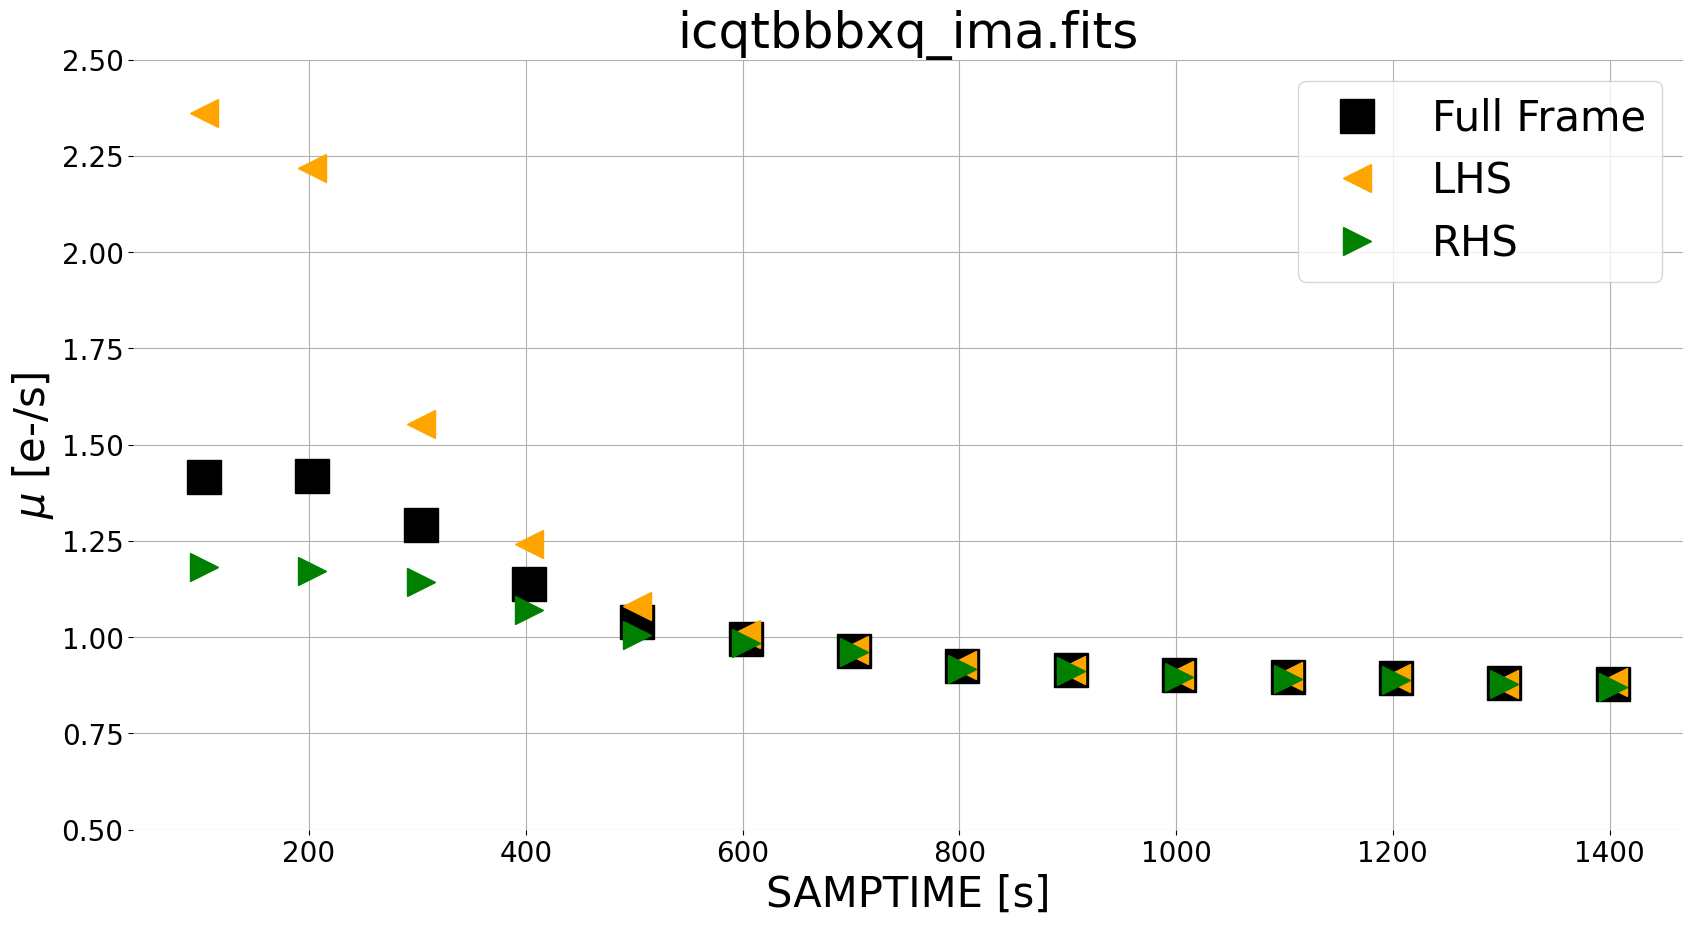

In [4]:
fig = plt.figure(figsize = (20, 10))

ima = f'orig/{file_id}_ima.fits'

path, filename = os.path.split(ima)
cube, integ_time = diff.read_wfc3(ima)


lhs_region = {"x0":50,"x1":250,"y0":100,"y1":900}
rhs_region = {"x0":700,"x1":900,"y0":100,"y1":900}

#Please use a limit that makes sense for your own data, when running your images through this notebook.
cube[np.abs(cube) > 3] = np.nan

diff_cube = diff.compute_diff_imas(cube, integ_time, diff_method = "instantaneous")
median_diff_fullframe, median_diff_lhs, median_diff_rhs = diff.get_median_fullframe_lhs_rhs(diff_cube, lhs_region = lhs_region, rhs_region = rhs_region)

plt.rc('xtick', labelsize = 20) 
plt.rc('ytick', labelsize = 20) 
plt.rcParams.update({'font.size': 30})
plt.rcParams.update({'lines.markersize': 15})

diff.plot_ramp(ima, integ_time, median_diff_fullframe, median_diff_lhs, median_diff_rhs)

plt.ylim(0.5,2.5)
_ = plt.title(filename)




Here, we utilize a few functions from our module `ima_visualization_and_differencing`. We use `read_wfc3` to grab the IMA data from all reads and corresponding integration times. We also implement upper and lower limits on our pixel values to exclude sources when plotting our ramp. We take the instantaneous difference using `compute_diff_imas`, which computes the difference as described in the equation above. Finally, we use `plot_ramp` to plot the median count rate from the left side, right side, and full frame image

For our scattered light exposure, we see  zodiacal light at a level of ~0.9e/s in later reads, with the scattered light component affecting the first several reads where the median count rate for the left side (orange triangles) is larger than the right side (green triangles). We can visualize this in 2 dimensions in the panel plot below, using `panel_plot`.

In the panel plot, we see that sources (small galaxies) are visible in the difference images using this new method. Note that this may complicate the analysis of the spatial background (e.g. left versus right) for images with extended targets, such as large galaxies. In this case, users may wish to adjust the regions of the detector used for the ramp plots. We therefore recommend inspecting both the panel plots as well as the ramp fits for diagnosing any issues with the data. 

IndexError: index 5 is out of bounds for axis 0 with size 5

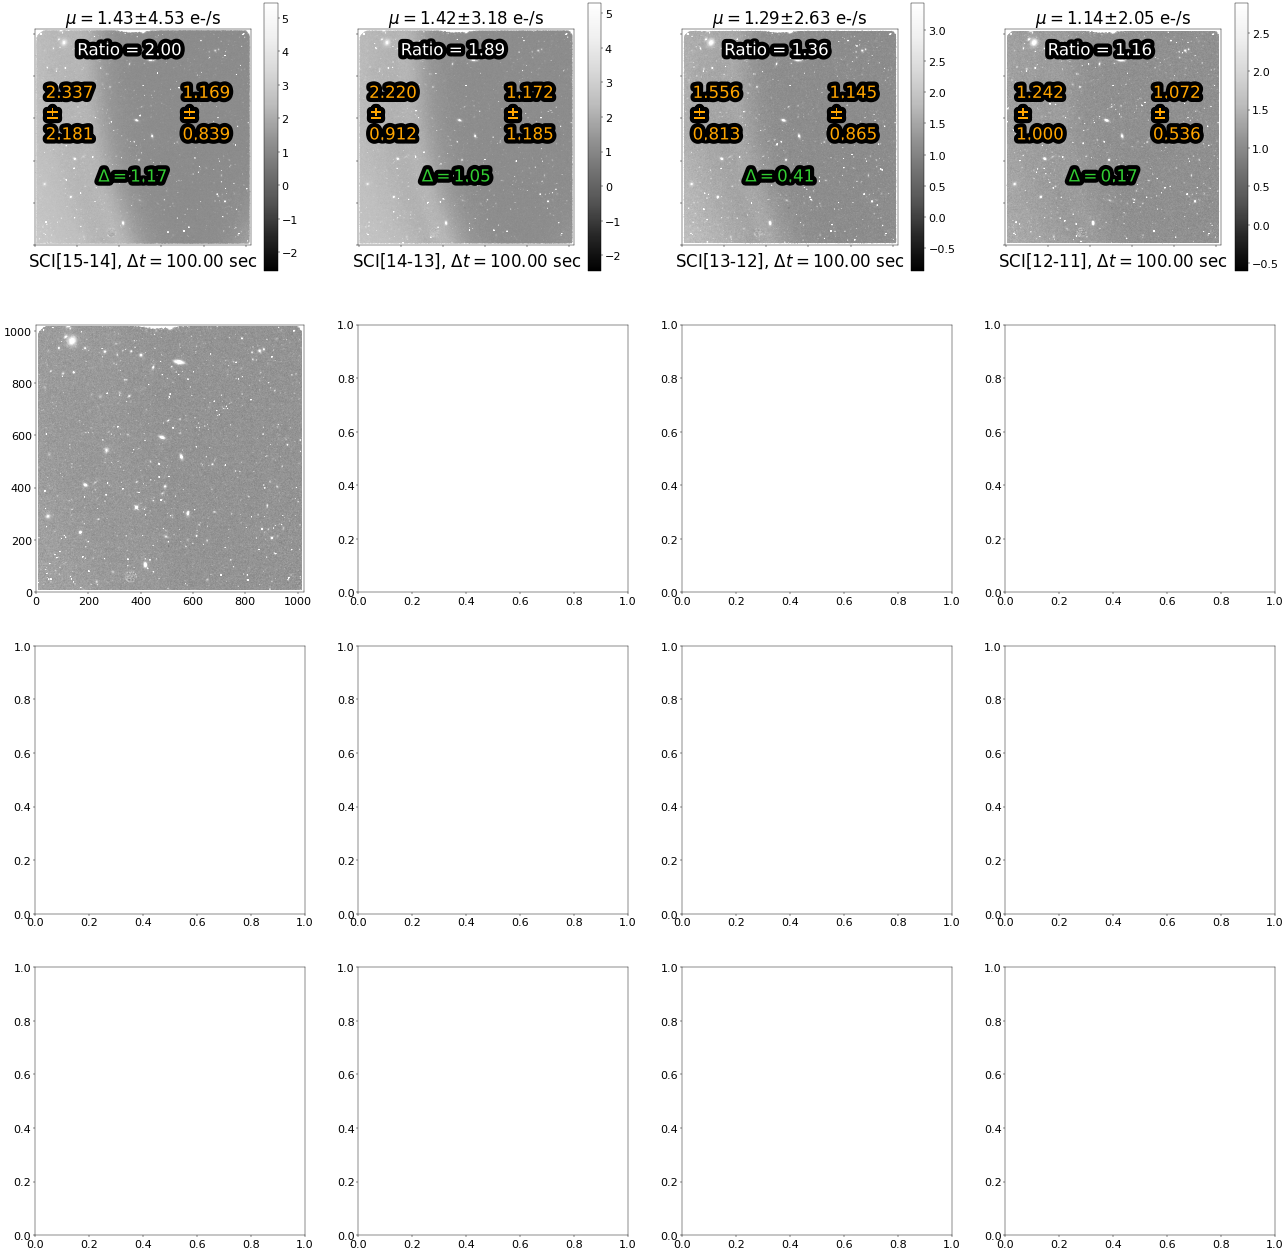

In [5]:
path,filename = os.path.split(ima)

cube, integ_time = diff.read_wfc3(ima)

lhs_region = {"x0":50,"x1":250,"y0":100,"y1":900}
rhs_region = {"x0":700,"x1":900,"y0":100,"y1":900}

median_fullframe, median_lhs, median_rhs = diff.get_median_fullframe_lhs_rhs(cube, lhs_region = lhs_region, rhs_region = rhs_region)

diff_cube = diff.compute_diff_imas(cube, integ_time, diff_method = 'instantaneous')

median_diff_fullframe, median_diff_lhs, median_diff_rhs = diff.get_median_fullframe_lhs_rhs(diff_cube, lhs_region = lhs_region, rhs_region = rhs_region)
standard_dev_fullframe, standard_dev_lhs, standard_dev_rhs = diff.get_std_fullframe_lhs_rhs(diff_cube, lhs_region = lhs_region, rhs_region = rhs_region)

fig_0 = diff.panel_plot(cube, integ_time, median_diff_fullframe, median_diff_lhs, median_diff_rhs, standard_dev_fullframe, standard_dev_lhs, standard_dev_rhs, diff_method = 'instantaneous')
_ = fig_0.suptitle(filename, fontsize = 40)
plt.subplots_adjust(bottom = 0.25, right = 0.9, top = 0.95)

In this figure, we see that the ratio of instantaneous rate for the left versus right side of the image is ~1.0 for all but the first few reads (which are affected by scattered light). We choose to exclude reads with a ratio greater than 1.1 from the final science data, as they are the reads most strongly affected by scattered light. While this reduces the total exposure from 1403 to 1000 seconds, it removes the spatial component from the sky background.

## 4. Querying CRDS for the Reference File<a id="ref"></a>

In this notebook, we will run `calwf3` to produce an IMA file, which we will use to remove bad reads. Before running `calwf3`, we need to set some environment variables.

We will point to a subdirectory called `crds_cache` using the IREF environment variable, which is used for WFC3 reference files. Other instruments use other variables, e.g., JREF for ACS.

In [ ]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['iref'] = './crds_cache/references/hst/wfc3/'

The code block below will query CRDS for the best reference files currently available for our dataset and update the header keywords to point to these new files. We will use `os` to run terminal commands. In the terminal, the line would be:

...where 'filename' is the name of your fits file.


**Warning: this cell may take a few minutes to complete.**

In [ ]:
raw_file = f'{file_id}_raw.fits'


print( f"Querying CRDS for the reference file associated with {raw_file}.")
command_line_input = 'crds bestrefs --files {:} --sync-references=1 --update-bestrefs'.format(raw_file)
os.system(command_line_input);

## 5. Correcting the Data<a id="main"></a>

To address anomalies such as scattered light, satellite trails, and more in WFC3/IR images  we can remove the individual affected reads and correct the science and error arrays accordingly. For our example image, we choose to exclude reads where the ratio of background signal is greater than 1.1 e-/s (see the notebook WFC3/IR IMA Visualization with An Example of Time Variable Background (O'Connor, in prep.) for a more complete demonstration of how we find this ratio).


### 5.1 Excising "Bad" Reads <a id="reprocess"></a>

In this section, we walk through the key steps to removing bad reads. 

We select our excluded reads (in this case reads reads SCI,15 through SCI, 11) and use the "remove_reads" function to effectively subtract out the reads affected by TVB. 

The key steps to this process are:

1. Run `calwf3` on the RAW image file to produce an IMA and an FLT.
2. Take the IMA file and subtract the science array from the "bad" reads from the cumulative exposure.
    - Correct the final integration time accordingly. 
3. Correct the error image extension to reflect the changes to the science array. 
4. Update the final FLT headers, science array, and error array.


We walk through this process below.

#### STEP 1: Run `calwf3`

In [ ]:
raw_filepath = f'{file_id}_raw.fits'
bad_reads = [11,12,13,14,15] #note, we leave the "zero read" (read number 16)

#### Remove any existing ima or flt products from working directory or calwf3 will not run 
for ext in ['flt','ima']:
    if os.path.exists(raw_filepath.replace('raw', ext)):
        os.remove(raw_filepath.replace('raw', ext))

In [ ]:
 ##run CALWF3
calwf3(raw_filepath)

#### STEP 2: Correct the IMA product

Here we walk through the process of subtracting the reads affected by Earth-limb scattered light from the cumulative science extension of the IMA. While an FLT product is also created in step 1, we do not use this file due to the poor-quality ramp fit in the presence of TVB.

Overall, the steps are as follows:

1. Load the science data as a 3D array and the integration time as a 1D array from the science and time extensions of the IMA file. In addition, load the associated dark reference file.

In [ ]:
ima = fits.open(raw_filepath.replace('raw', 'ima'))

cube, integ_time = diff.read_wfc3(raw_filepath.replace('raw', 'ima'))

dark_file = ima[0].header['DARKFILE'].replace('iref$', os.getenv('iref'))
dark_cube, dark_time = diff.read_wfc3(dark_file)

2. Convert science data from electrons/second to electrons.

In [ ]:
cube_counts = np.zeros(np.shape(cube))
dark_counts = np.zeros(np.shape(dark_cube))
for img in range(cube.shape[2]):
    cube_counts[:,:,img] = cube[:,:,img]*integ_time[img]
    dark_counts[:,:,img ] = dark_cube[:,:,img]

3. Compute the difference between reads (the cumulative difference, in this case) to isolate counts and integration time from bad reads.

In [ ]:
cube_diff = np.diff(cube_counts, axis = 2)
dark_diff = np.diff(dark_counts, axis = 2)
dt = np.diff(integ_time)

4. For each bad read, subtract the counts (and time) from ONLY that read from the total data.

In [ ]:
final_dark = dark_counts[:,:,-1] 

final_sci = cube_counts[:,:,-1]
final_time = np.ones((1024, 1024))*integ_time[-1]

print(np.nanmean(final_sci))
if (len(bad_reads) > 0):
    for read in bad_reads:
        index = cube_counts.shape[2]-read-1
        print(read,index)#because the reads are stored in reverse order
        
        print(dt[index])
        final_sci -= cube_diff[:,:,index]
        final_dark -= dark_diff[:,:,index]
        final_time -= dt[index]
        

In [ ]:
print(np.mean(cube_diff[:,:,0]))

#### STEP 3: Correct the Error Image

The errors associated with the raw data are estimated according  to the noise model for the detector which currently includes a simple combination of detector readnoise and poisson noise from the pixel and which is intended to replicate the `calwf3` error array calculation. Currently, the inital detector noise model (in electrons) is as follows, where RN is the readnoise.

$$ SCI_{1} = signal= (flux*flat + dark)$$ 

$$ \sigma_{1} = \sqrt{(RN^{2}) + (flux*flat + dark)} $$


Note that our signal equation includes flat and dark corrections to revert the final science array (flux) produced by `calwf3` to the original signal (in electrons) recorded in the detector.

The ERR array continues to be updated as the SCI array is processed. The dark error term is added in quadrature as the dark current is subtracted from the science array:

$$ SCI_{2} = signal - dark $$

$$ \sigma_{2} = \sqrt{\sigma_{1}^{2}+\sigma_{dark}^{2}} $$

Next, the flat images are divided out of the science image. There are two flat-fields (p-flat and delta-flat), which are each divided out of the science image. The flat errors are combined using the correct error propagation method.

 $$ flat = pflat * dflat $$

P-Flat (pflat) file:

$$ SCI_{3} = SCI_{2}/pflat $$

$$ \frac{\sigma_{3}}{SCI_{3}} = \sqrt{ (\frac{\sigma_{2}}{SCI_{2}})^{2} +(\frac{\sigma_{pflat}}{pflat})^{2}} $$

Delta-Flat (dflat) file:

$$ SCI_{4} = SCI_{3}/dflat $$

$$ \frac{\sigma_{4}}{SCI_{4}} = \sqrt{ (\frac{\sigma_{3}}{SCI_{3}})^{2} +(\frac{\sigma_{dflat}}{dflat})^{2}} = \sqrt{ (\frac{\sigma_{2}}{SCI_{2}})^{2} +(\frac{\sigma_{pflat}}{pflat})^{2} +(\frac{\sigma_{dflat}}{dflat})^{2}}$$


and finally it is converted to an error in electrons/second as:

 $$ \sigma_{e^{-}/s}= \frac{\sigma_{4}}{exptime}$$
 
Evaluating this equation, we come up with an equation for error array calculation (in electrons/second) which we use in our Python calculations as follows:

$$ \sigma_{e^{-}/s}= \frac{\sqrt{ RN^{2} + (flux*(pflat*dflat) + dark) +  \sigma_{dark}^{2} + (\sigma_{pflat}*flux*dflat)^{2} + (\sigma_{dflat}*flux*pflat)^{2} }}{pflat*dflat*exptime}$$

If we treat the pflat and dflat terms as one general flat term, we can rewrite the error equation more simply as:

$$ \sigma_{e^{-}/s}= \frac{\sqrt{ RN^{2} + (flux*flat + dark) +  \sigma_{dark}^{2} + (\sigma_{flat}*flux*flat)^{2} }}{flat*exptime}$$


We do not address the error propagation through the nonlinearity correction step of `calwf3` (NLINCORR), as it is complicated and sufficiently small to be outside of the scope of this notebook. 

In [ ]:
NSAMP = ima[0].header['NSAMP']
##getting variance terms
#### Readnoise in 4 amps
RN = np.zeros((1024,1024))
RN[512: ,0:512] += ima[0].header['READNSEA']
RN[0:512,0:512] += ima[0].header['READNSEB']
RN[0:512, 512:] += ima[0].header['READNSEC']
RN[512: , 512:] += ima[0].header['READNSED']


#### Gain in 4 amps
gain_2D = np.zeros((1024,1024))
gain_2D[512: ,0:512] += ima[0].header['ATODGNA']
gain_2D[0:512,0:512] += ima[0].header['ATODGNB']
gain_2D[0:512, 512:] += ima[0].header['ATODGNC']
gain_2D[512: , 512:] += ima[0].header['ATODGND']

#dark image
dark_im = fits.open(dark_file)

##And grabbing the flats
pflat_file = ima[0].header['PFLTFILE'].replace('iref$', os.getenv('iref'))
pflat_im = fits.open(pflat_file)
pflat = pflat_im[1].data
pflat_error=pflat_im['ERR'].data

dflat_file = ima[0].header['DFLTFILE'].replace('iref$', os.getenv('iref'))
dflat_im = fits.open(dflat_file)
dflat = dflat_im[1].data
dflat_error=dflat_im['ERR'].data

#Computing the final error

#### Variance terms

## poisson error: sqrt(signal), flux = final_sci, dark is converted to electrons
signal = (final_sci*(pflat*dflat)+final_dark*gain_2D)
## flat errors
#pflat
pflat_err = (pflat_im['ERR'].data)
#dflat
dflat_err = (dflat_im['ERR'].data)
#dark error
dark_err = (dark_im['ERR'].data)*gain_2D 
##final
final_err = np.sqrt(RN**2 + signal + (dark_err**2) + (pflat_err*final_sci*dflat)**2\
                  + (dflat_err*final_sci*pflat)**2)
    
final_err /= (pflat*dflat*final_time)

#and finally the final science image (converted back to count rate)
final_sci /= final_time      

In [ ]:
final_err[5:-5,5:-5]

#### STEP 4: Update the FLT Product

Finally, we update the FLT product created in step 1 with the new science array, error array, and header keywords (such as the new total exposure time).

In [ ]:
flt = fits.open(raw_filepath.replace('raw', 'flt'), mode='update')
 
#Updating the flt data

flt['SCI'].data = final_sci[5:-5,5:-5]
flt['ERR'].data = final_err[5:-5,5:-5]


# Updating the FLT header
flt[0].header['IMA2FLT'] = (1, 'FLT extracted from IMA file')
flt[0].header['EXPTIME'] = np.max(final_time)
flt[0].header['NPOP'] = (len(bad_reads), 'Number of reads popped from the sequence')

flt.flush()

#### Putting It All Together

Below, we have included the entire correction process (steps 1-4 above) in a function, for convenience. 

In [ ]:
def remove_reads(raw_filepath, bad_reads = []):
    '''
    From the final IMA read, subtract data of reads affected by anomalies.
    Compute a corrected science image and error image, and place them in the FLT product. 
    
    Parameters
    ----------
    raw_filepath: str
        Path to a RAW full-frame IR image fits file.
        
    bad_reads: list of int
        List of the IMSET numbers (science extension numbers) of reads affected by anomalies.
    '''
    
    #### Remove existing products or calwf3 will die
    for ext in ['flt','ima']:
        if os.path.exists(raw_filepath.replace('raw', ext)):
            os.remove(raw_filepath.replace('raw', ext))
    
    #### Run calwf3
    calwf3(raw_filepath)
    
    #take calwf3 produced IMA, get rid of bad reads 
    flt = fits.open(raw_filepath.replace('raw', 'flt'), mode = 'update')
    ima = fits.open(raw_filepath.replace('raw', 'ima'))
    
    NSAMP = ima[0].header['NSAMP']
    ##getting variance terms
    #### Readnoise in 4 amps
    readnoise_2D = np.zeros((1024,1024))
    readnoise_2D[512: ,0:512] += ima[0].header['READNSEA']
    readnoise_2D[0:512,0:512] += ima[0].header['READNSEB']
    readnoise_2D[0:512, 512:] += ima[0].header['READNSEC']
    readnoise_2D[512: , 512:] += ima[0].header['READNSED']
    

    #### Gain in 4 amps
    gain_2D = np.zeros((1024,1024))
    gain_2D[512: ,0:512] += ima[0].header['ATODGNA']
    gain_2D[0:512,0:512] += ima[0].header['ATODGNB']
    gain_2D[0:512, 512:] += ima[0].header['ATODGNC']
    gain_2D[512: , 512:] += ima[0].header['ATODGND']
    
    #getting darks
    dark_file = ima[0].header['DARKFILE'].replace('iref$', os.getenv('iref')+'/')
    dark_im = fits.open(dark_file)
    
    #and flats
    pflat_file = ima[0].header['PFLTFILE'].replace('iref$', os.getenv('iref')+'/')
    pflat_im = fits.open(pflat_file)
    pflat = pflat_im[1].data
    pflat_error = pflat_im['ERR'].data
    
    dflat_file = ima[0].header['DFLTFILE'].replace('iref$', os.getenv('iref')+'/')
    dflat_im = fits.open(dflat_file)
    dflat = dflat_im[1].data
    dflat_error = dflat_im['ERR'].data
    
    cube, integ_time = diff.read_wfc3(raw_filepath.replace('raw','ima'))
 
    
    dark_cube, dark_time = diff.read_wfc3(dark_file) 

    
    #from rate to counts 
    cube_counts = np.zeros(np.shape(cube))
    dark_counts = np.zeros(np.shape(dark_cube))
    for img in range(cube.shape[2]):
        cube_counts[:,:,img] = cube[:,:,img]*integ_time[img]
        dark_counts[:,:,img] = dark_cube[:,:,img]/dark_time[img]*integ_time[img]
    
    #diff between reads
    difference = np.diff(cube_counts, axis=2)
    dark_diff = np.diff(dark_counts, axis=2)
    dt = np.diff(integ_time)
    
    
    final_dark = dark_counts[:,:,-1]*1  
    final_sci = cube_counts[:,:,-1]*1
    final_time = np.ones((1024, 1024))*integ_time[-1]
    if (len(bad_reads) > 0):
        for read in bad_reads:
            index = cube_counts.shape[2]-read
            final_sci -= difference[:,:,index]
            final_dark -= dark_diff[:,:,index]
            final_time -= dt[index]
            
    
    
   #Computing the final error

    #### Variance terms
    ### read noise
    RN = readnoise_2D
    ## poisson error: sqrt(signal), flux = final_sci, dark is converted to electrons
    signal = (final_sci*(pflat*dflat)+final_dark*gain_2D)
    ## flat errors
    #pflat
    pflat_err = (pflat_im['ERR'].data)
    #dflat
    dflat_err =(dflat_im['ERR'].data)
    #dark error
    dark_err = (dark_im['ERR'].data)*gain_2D 
    ##final
    final_err = np.sqrt(RN**2 + signal + (dark_err**2) + (pflat_err*final_sci*dflat)**2\
                      + (dflat_err*final_sci*pflat)**2)

    final_err /= (pflat*dflat*final_time)
    
    #and finally the final science image (converted back to count rate)
    final_sci /= final_time      
    
    #updating the flt

    flt['SCI'].data = final_sci[5:-5,5:-5]
    flt['ERR'].data = final_err[5:-5,5:-5]
    
   
     ### Update the FLT header
    flt[0].header['IMA2FLT'] = (1, 'FLT extracted from IMA file')
    flt[0].header['EXPTIME'] = np.max(final_time)
    flt[0].header['NPOP'] = (len(bad_reads), 'Number of reads popped from the sequence')
    
    
    for iread, read in enumerate(bad_reads):
        flt[0].header['POPRD%02d' %(iread+1)] = (read, 'Read kicked out of the MULTIACCUM sequence')
    
    flt.flush()

### 5.2 Comparing FLT Products <a id="compare"></a>

You may want to move your reprocessed images to a new directory, especially if you plan to run the notebook again. 

In [ ]:
reprocessed_flt = f'{file_id}_flt.fits'
reprocessed_ima = f'{file_id}_ima.fits'
original_flt = f'orig/{file_id}_flt.fits'
original_ima = f'orig/{file_id}_ima.fits'


Now, we can compare our original and reprocessed FLT products.

In [ ]:

image_new = fits.open(reprocessed_flt)
image_old = fits.open(original_flt)

fig = plt.figure(figsize = (20, 7))
fig
rows = 1
columns = 2

#add the total exptime in the title 
ax1 = fig.add_subplot(rows, columns, 1)
ax1.set_title("Reprocessed FLT image", fontsize = 20)
im1 = plt.imshow(image_new["SCI", 1].data, vmin = 0.8, vmax = 1.3, origin = 'lower', cmap = 'Greys_r')
ax1.tick_params(axis = 'both',labelsize = 10)
cbar1 = plt.colorbar(im1, ax = ax1)
cbar1.ax.tick_params(labelsize = 10)

ax2 = fig.add_subplot(rows, columns, 2)
ax2.set_title("Original FLT image", fontsize = 20)
im2=plt.imshow(image_old["SCI", 1].data, vmin = 0.8, vmax = 1.3, origin = 'lower',  cmap = 'Greys_r')
ax2.tick_params(axis = 'both', labelsize = 10)
cbar2 = plt.colorbar(im2, ax = ax2)
cbar2.ax.tick_params(labelsize = 10)

plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 


This new image was produced by subtracting the signal from the first 5 reads (not including the 0 read) from the final science data, reducing the effective exposure time from 1403 to 1000 seconds. While the total exposure is reduced from 1403 seconds to 1000 seconds (thus decreasing the overall S/N of the image), the background in the reprocessed image is now uniform over the entire field of view. We can see that the new FLT image is free of the Earth limb scattered light visible in the old FLT image. 

In [ ]:
print('The final exposure time after reprocessing is {}.'.format(image_new[0].header['EXPTIME']))

## 6. Conclusions <a id="conclusions"></a>

**Congratulations, you have completed the notebook.**

You should now be familiar with how to reprocess an observation affected by Earth limb scattered light by removing the affected reads from your science and error images. 

Thank you for following along! 

## Additional Resources <a id="add"></a>


Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
    - [WFC3/UVIS CTE Website](https://www.stsci.edu/hst/instrumentation/wfc3/performance/cte)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
- [Instrument Science Report WFC3 2021-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-01.pdf)

## About this Notebook <a id="about"></a>


**Author:** Anne O'Connor, Jennifer Mack, Annalisa Calamida, Harish Khandrika -- WFC3 Instrument

**Updated On:** 2023-03-24

## Citations <a id="cite"></a>

If you use the following tools for published research, please cite the
authors. Follow these links for more information about citing the tools:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)
* [Citing `wfc3tools`](https://wfc3tools.readthedocs.io/en/latest/)
* [Citing `drizzlepac`](https://drizzlepac.readthedocs.io/en/latest/LICENSE.html)


If you use this notebook, or information from the WFC3 Data Handbook, Instrument Handbook,
or WFC3 ISRs for published research, please cite them:

* [Citing the WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb#:~:text=Citation,%2C%20(Baltimore%3A%20STScI).)
* [Citing the WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb#:~:text=Citation,14.0%E2%80%9D%20(Baltimore%3A%20STScI))
* [Instrument Science Report WFC3 2021-01](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2021/2021-01.pdf)
* Citing this notebook:
    Please cite the primary author and year, and hyperlink the notebook or WFC3 Library
***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 